***
***

# **COVID-19 Vaccination Progress**

## *6) Feature Selection for Prediction and Time Series Specific EDA*

***
***

## Table of Contents

| 1. INTRODUCTION | 2. Visualisations | 3. SUMMARY |
|----|----|----|
| *1.1 Dataset Characteristics* | *2.1 Importing Libraries and Data* | 3.1 Key Findings |
| | *2.2 Feature Selection* | 3.2 Next Steps |
| | *2.3 Detrend to Achieve Stationarity* | |

***
***

## 1. INTRODUCTION

In this notebook we use the cleaned/ feature-engineered dataset generated in notebook 1 (Initial Data Exploration, Cleaning and Feature Engineering) for an in-depth analysis. The focus of this notebook will be on time series specific EDA and detrending.

***

### 1.1 Dataset Characteristics

1) Our PROCESSED dataframe contains the following:

| FEATURE | description | comment |
|----|----|----|
| **date** | data entry (13th December 2020 to 24th March 2021) | - |
| **weekday** | day of week (e.g. Monday) | NEW column added during feature engineering |
| **country** | 147 countries | 4 duplicates removed, UN recognises 197 countries (193 are members) |
| **country_grouped** | 17 countries/groups | NEW column added during feature engineering |
| **4 x vaccine type columns** | inactivated_virus, recombinant, rna, protein | NEW columns added during feature engineering |
| **10 x vaccine columns** | name/company | NEW columns added during cleaning to replace vaccines column |
| **daily_vaccinations** | no. of vaccination for that date/country | some days only daily vaccinations, some days only the (cummulative) total |
| **daily_vaccinations_per_million** | ratio (in ppm) between vaccination number and total population for the current date in the country | - |
| **daily_vaccinations_per_hundred** | ratio (in percent) between vaccination number and total population for the current date in the country | NEW column added during feature engineering |
| **daily_vaccinations_raw** | daily vaccinations as CHANGE COMPARED TO PREVIOUS DAY | calculation: total_vaccinations (day) - total_vaccination (previous day) |
| **total_vaccinations** | absolute number of immunisations (jabs) in the country | some days only daily vaccinations, some days only the (cummulative) total |
| **total_vaccinations_per_hundred** | ratio (in percent) between vaccination number and total population up to the date in the country | - |
| **people_vaccinated** | total no. of people with immunisation (partial and full) | - |
| **people_vaccinated_per_hundred** | ratio (in percent) between population immunized (partial and full) and total population | - |
| **people_fully_vaccinated** | total no. of people with full immunisation (typically 2) | - |
| **people_fully_vaccinated_per_hundred** | ratio (in percent) between population fully immunized and total population | - |
| **people_partially_vaccinated** | total no. of people with partial immunisation (i.e. 1 jab) | NEW column added during feature engineering |
| **people_partially_vaccinated_per_hundred** | ratio (in percent) between population partially immunized and total population | NEW column added during feature engineering |

***
***

## 2. IMPORTS AND DATA PREPARATION

***

### 2.1 Importing Libraries and Data

+ Import numpy (linear algebra), pandas (data processing), visualisation libraries (matplotlib, seaborn, plotly) and statsmodel.
+ Import original and processed (notebook 1) dataset on COVID-19 vaccination progress.

In [1]:
#Import basic libraries
import numpy as np #Linear algebra
import pandas as pd #Data processing

#Import libraries for time series analysis
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

#Suppress pandas future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Plot settings
%matplotlib inline
dpi_var=150

In [2]:
#Import processed and global datasets (see notebook 1)
df_processed = pd.read_csv('data/df_processed.csv', parse_dates=['date'])
df_processed.sort_values('date', inplace=True)
df_global = pd.read_csv('data/df_global.csv', parse_dates=['date'])
df_global.sort_values('date', inplace=True)

#Generate additional dataframes with date as index
df_processed_date = df_processed.set_index('date')
df_global_date = df_global.set_index('date')

***

### 2.2 Feature Selection

In this section an in-depth analysis of the vaccination progress data was carried out to identify the most suitable features for time series pediction/forecasting.

**TASK 1**:

Identify suitable feature(s) for time series prediction/forecasting with respect to the key objective.

***
***

***KEY OBJECTIVE: To forecast the daily vaccinations per country for the next 7-14 days reflecting not only the upward trend but also and most importantly capture the daily fluctuations.***

***
***

***Background Information:*** Since the only feature with essentially no missing values, i.e. daily vaccinations, has been generated by a 7-day rolling/smoothing window technique (for more details see notekook 3) we won't look further into predictions based on this feature, especially since the imputed values cannot easily be identified. Therefore, we will concentrate on total vaccinations, daily vaccinations (raw) and people vaaccinated (partially/fully and fully vaccinated). These feature have 38% to 62% missing values from the perspective of the entire dataset, i.e. all countries (see notebook 1). The number of missing values might be attributed to certain countries not supplying certain data. Therefore, the first step is to check this out and possibly identify countries that have few missing numbers with respect to these features, which are suitable for modelling. We start by investigating the following countries: Germany, UK, USA, Israel, India, Russia and China.

The following features won't be considered:
+ % And ppm columns are not of key interest since we want to predict the absolute numbers of vaccinations, their upward trend and their daily fluctuations, and they are essentially covered in corresponding 'absolute value' columns.
+ The vaccine features are not relevant for predicting vaccination number as the information is not detailed enough.

**KEY FINDINGS**:

Reagarding total vaccinations and daily_vaccinations (raw):
+ For Germany and Israel we have no missing values from December onwards. Hence, we will start our investigations with these 2 countries (PRIO1).
+ India has very few missing values from mid-January onwards. We can impute these numbers and then investigate India as well (PRIO2). it is unlikely that there were no vaccinations on these days, so we will consider imputing from the previous day(s) (with regard to daily vaccinations). In order to decide how to proceed we need to look into the data in more detail (later).
+ The UK and USA reported sporadically during December 2020 but continuously from mid-January 2021 onwards. Hence we will have less data, but a continuous series and will investigate these countries with PRIO2.
+ There are too many missing values for China and Russia to sensibly impute data. Therefore, currently it will not be possible to make predictions for these countries. with respect to the above key objective. There is more data available for daily vaccinations, but since this feature is imputed we would need to check out if we can reverse engineer it to identify the imputed values.

Regarding people vaccinated (partially/fully and fully vaccinated):
+ With respect to people vaccinated (partially and fully) there is enough data available for certain countries with few missing values (continuous, mainly in December and early January). Hence, this could be analysed and predicted, but since this is a mixture of partially and fully vaccinated people the picture won#t be complete without this additional information.
+ Not enough data for people fully vaccinated is availabe yet, as 4-6 weeks delay between 1st and 2nd shot. Hence this cannot be analysed or predicted as yet.

To conclude, we will start by investigating daily vaccinations (raw) worldwide and for Germany, Israel. It should be noted that the worldwide accumulated data has, of course, no missing values, but in essence the missing values for certain countries are masked. This is undesirable, but nonetheless a real world example and thus we will include the global progress as well as the 2 selected countries.

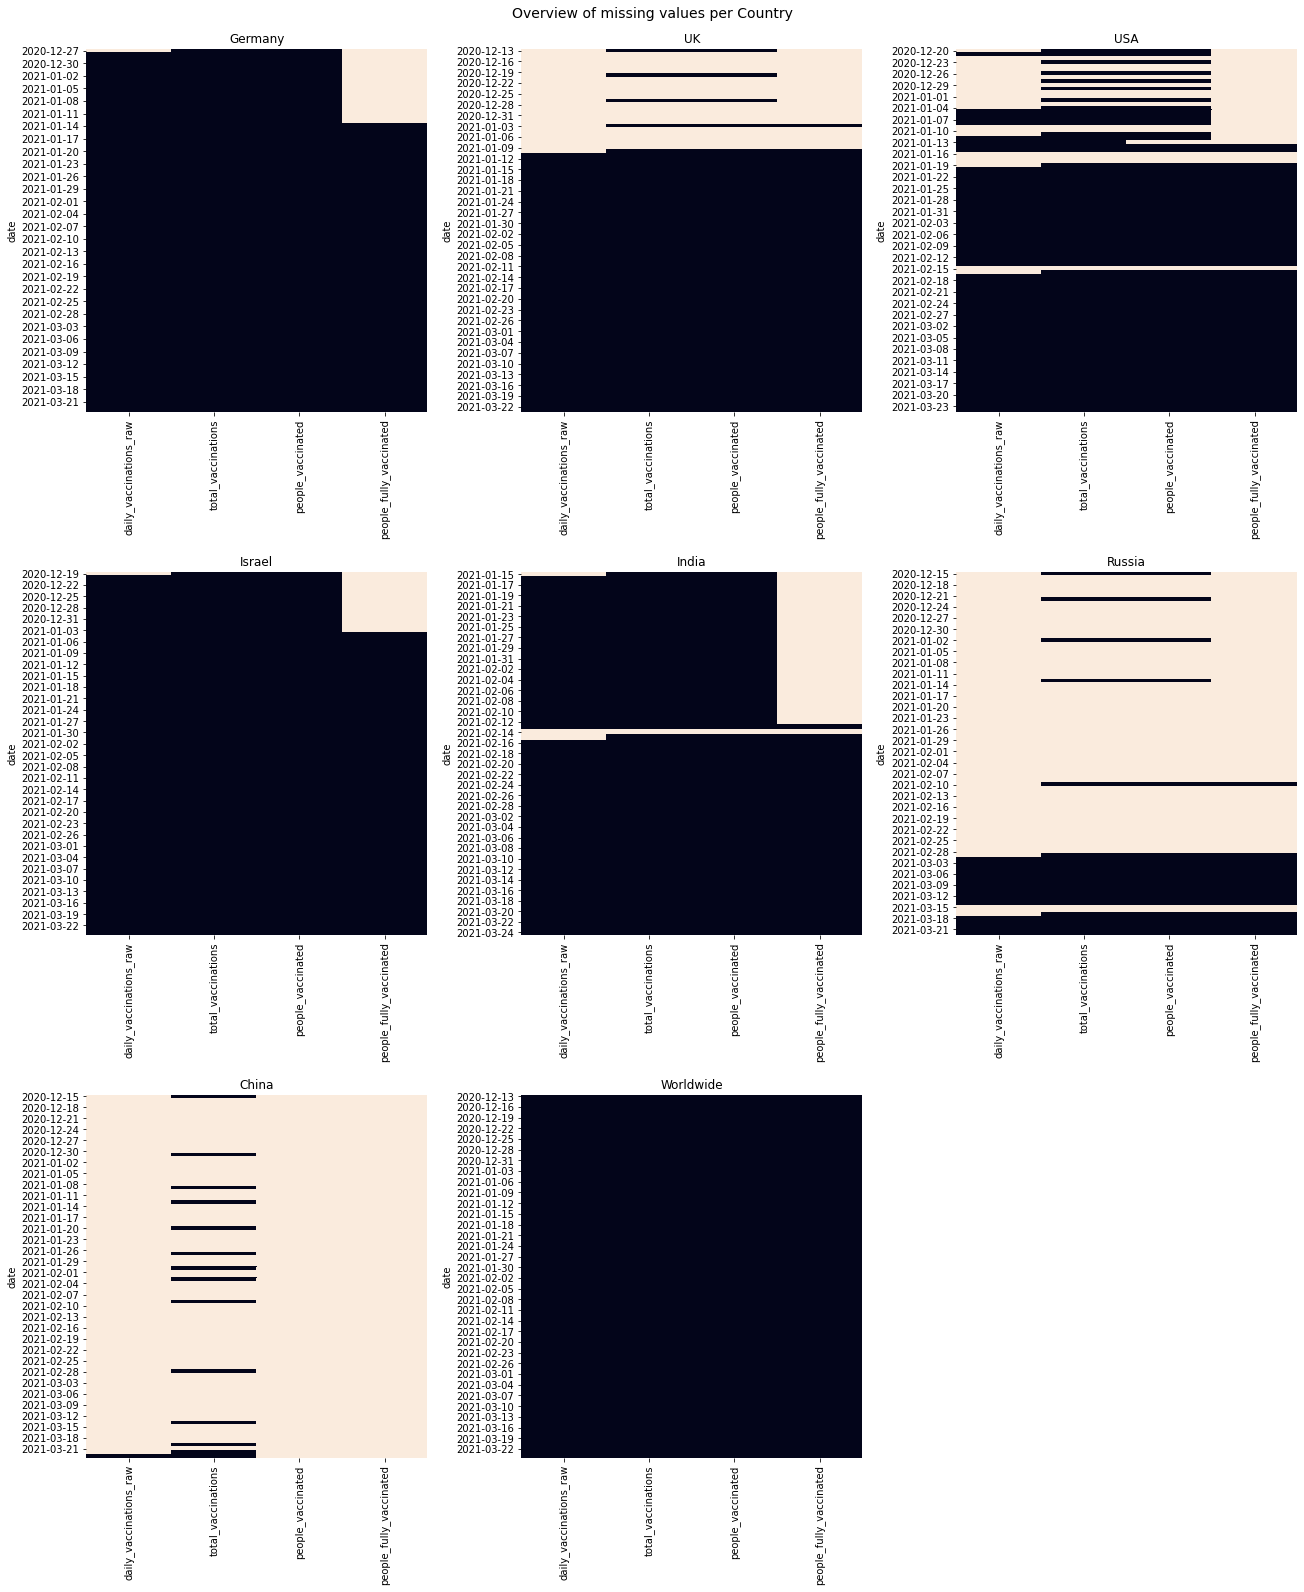

In [3]:
#Closer look at missing values for key features (4) and selected countries
#Define subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18,22), constrained_layout=True)
ax[2, 2].set_visible(False)

#Filtered data frames for selected countries
filtered_1 = df_processed_date[df_processed_date['country']=='Germany']
filtered_2 = df_processed_date[df_processed_date['country']=='United Kingdom']
filtered_3 = df_processed_date[df_processed_date['country']=='United States']
filtered_4 = df_processed_date[df_processed_date['country']=='Israel']
filtered_5 = df_processed_date[df_processed_date['country']=='India']
filtered_6 = df_processed_date[df_processed_date['country']=='Russia']
filtered_7 = df_processed_date[df_processed_date['country']=='China']

#Plot seaborn heatmaps to visualise NaNs
sns.heatmap(filtered_1[['daily_vaccinations_raw', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']]
                .to_period('D').isnull(), cbar=False, ax=ax[0,0])
sns.heatmap(filtered_2[['daily_vaccinations_raw', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']]
                .to_period('D').isnull(), cbar=False, ax=ax[0,1])
sns.heatmap(filtered_3[['daily_vaccinations_raw', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']]
                .to_period('D').isnull(), cbar=False, ax=ax[0,2])
sns.heatmap(filtered_4[['daily_vaccinations_raw', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']]
                .to_period('D').isnull(), cbar=False, ax=ax[1,0])
sns.heatmap(filtered_5[['daily_vaccinations_raw', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']]
                .to_period('D').isnull(), cbar=False, ax=ax[1,1])
sns.heatmap(filtered_6[['daily_vaccinations_raw', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']]
                .to_period('D').isnull(), cbar=False, ax=ax[1,2])
sns.heatmap(filtered_7[['daily_vaccinations_raw', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']]
                .to_period('D').isnull(), cbar=False, ax=ax[2,0])
sns.heatmap(df_global_date[['daily_vaccinations_raw', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']]
                .to_period('D').isnull(), cbar=False, ax=ax[2,1])

#Set plot titles
fig.suptitle('Overview of missing values per Country', fontsize='14')
ax[0, 0].title.set_text('Germany')
ax[0, 1].title.set_text('UK')
ax[0, 2].title.set_text('USA')
ax[1, 0].title.set_text('Israel')
ax[1, 1].title.set_text('India')
ax[1, 2].title.set_text('Russia')
ax[2, 0].title.set_text('China')
ax[2, 1].title.set_text('Worldwide')

plt.show();

**TASK 2**:

Further investigate the three timeseries for daily vaccinations (raw):
+ Worldwide
+ Germany
+ Israel

***Note:*** This feature was originally generated from the total vaccinations data and supplied with Kaggle dataset.

**KEY FINDINGS**:

1) The first plot shows the worldwide daily vaccinations (raw) versus the daily vaccinations (7-day window/smoothing) and it can clearly bee seen that the imputed values are at the higher end of the raw values. The second plot shows the rolling-7-day average of the daily vaccinations (raw) in comparison to the original daily vaccinations (raw). Here we clearly see it reflecting the mean. Thus, we can once again confirm the discrepancy between the total vaccinations (and daily vaccinations(raw)) and the daily vaccinations (with imputation oof missing numbers).

2) The third plot shows the daily vaccinations (raw) for Germany and Israel confirming that all three timeseries (incl. worlwide) show an expected upward trend with most likely weekly seasonality.

3) Plot four shows a monthly comparison for the data for each of the three timeseries and confirms the above findings. It also nicely highlights the similarities and differences between the three series.

4) The distribution pattern in plot five show the right skewedness of the three time series.

5) Anf finally, lag plots (1, 7 and 30 days) show clear positive trends, whereby the correlation declines with the number of lags and from visual inspection appears to be weaker for Israel. Since the correlation is linear in all 3 cases an autoregressive model is probably the best choice.

In conclusion, since for all three series mean and variance are time dependent we have trend and seasonality so we don't have stationary time series. The next step will be to decompose and detrend the series.

In [4]:
#New dataframe for total vaccinations, daily_vaccinations_raw and daily vaccinations
#Worldwide and two selected countries (Germany and Israel)
df_timeseries = df_global_date[['total_vaccinations', 'daily_vaccinations_raw', 'daily_vaccinations']].join(
                                filtered_1.total_vaccinations, rsuffix='_germany').join(
                                filtered_2.total_vaccinations, rsuffix = '_israel').join(
                                filtered_1.daily_vaccinations_raw, rsuffix = '_germany').join(
                                filtered_2.daily_vaccinations_raw, rsuffix = '_israel').join(
                                filtered_1.daily_vaccinations, rsuffix = '_germany').join(
                                filtered_2.daily_vaccinations, rsuffix = '_israel')

In [5]:
#Save 3 separate timeseries for use in later notebooks
df_wrld = df_timeseries.daily_vaccinations_raw.to_csv('data/df_wrld.csv')
df_ger = df_timeseries.daily_vaccinations_raw_germany.to_csv('data/df_ger.csv')
df_isr = df_timeseries.daily_vaccinations_raw_israel.to_csv('data/df_isr.csv')

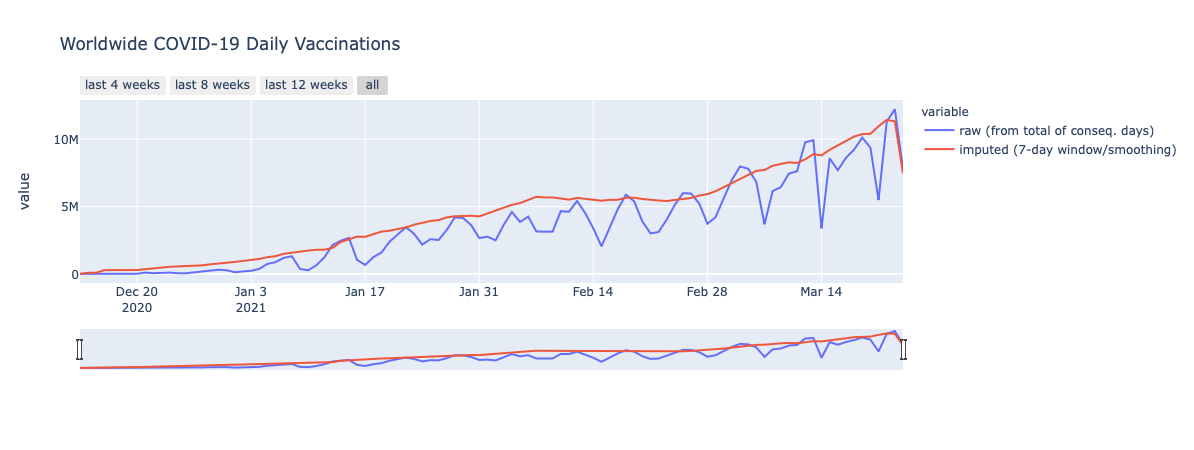

In [6]:
#Interactive PlotlyExpress graph for worldwide daily vaccinations (raw and imputed rolling/smoothing 7-day)
fig = px.line(df_timeseries.reset_index(), x='date', y=['daily_vaccinations_raw', 'daily_vaccinations'],
              title='Worldwide COVID-19 Daily Vaccinations',
              labels={'date': ''})

#Specify plot legend
fig.data[0].name='raw (from total of conseq. days)'
fig.data[1].name='imputed (7-day window/smoothing)'

#Define range slider and time-span buttons
fig.update_xaxes(
                rangeslider_visible=True,
                rangeselector=dict(
                    buttons=list([
                        dict(count=1, label='last 4 weeks', step='month', stepmode='backward'),
                        dict(count=2, label='last 8 weeks', step='month', stepmode='backward'),
                        dict(count=3, label='last 12 weeks', step='month', stepmode='backward'),
                        dict(step='all')
                        
                    ])
                )
)


fig.show();

![](images/nb6_fig1.png)

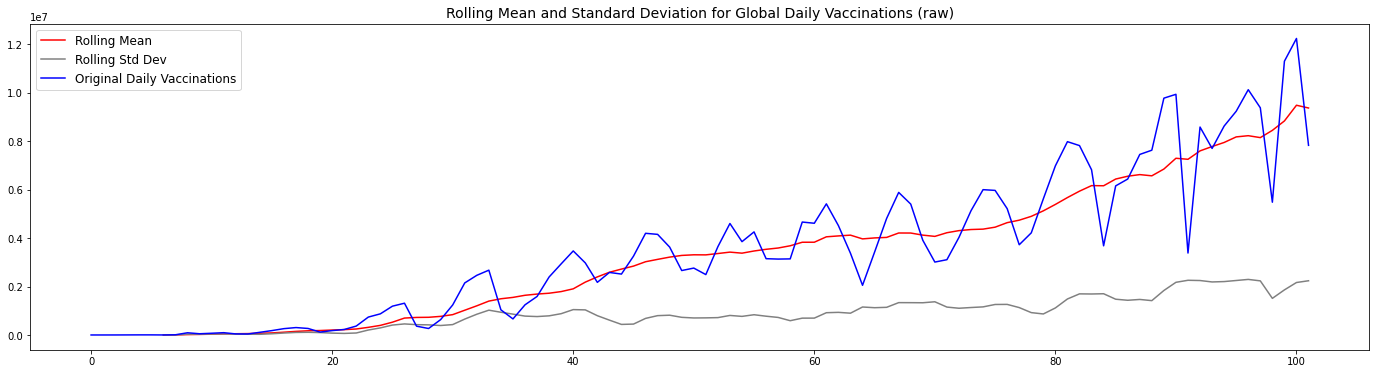

In [7]:
#Plot Rolling mean for worldwide daily vaccinations (raw) 
#Create dataframe for plotting
df_plot = df_timeseries.reset_index()

#Calculate rolling mean (simple moving average) and rolling standard deviation
rolling_mean = df_plot.daily_vaccinations_raw.rolling(7).mean()
rolling_std_dev = df_plot.daily_vaccinations_raw.rolling(7).std()
 
#Plot the statistics
plt.figure(figsize=(24,6))
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std_dev, color='grey', label = 'Rolling Std Dev')
plt.plot(df_plot.daily_vaccinations_raw, color='blue',label='Original Daily Vaccinations')

#Specify legend location and set title
plt.legend(loc='best', fontsize='12')
plt.title('Rolling Mean and Standard Deviation for Global Daily Vaccinations (raw)', size=14)

plt.show();

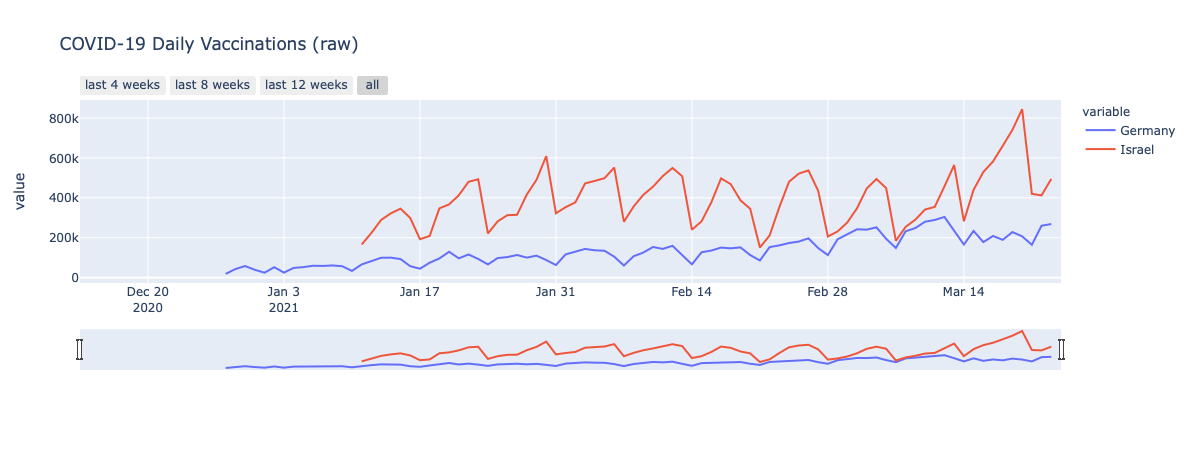

In [8]:
#Interactive PlotlyExpress graph for daily vaccinations (raw) --- Germany and Israel
fig = px.line(df_timeseries.reset_index(), x='date', y=['daily_vaccinations_raw_germany', 'daily_vaccinations_raw_israel'],
              title='COVID-19 Daily Vaccinations (raw)',
              labels={'date': ''})

#Specify plot legend
fig.data[0].name='Germany'
fig.data[1].name='Israel'

#Define range slider and time-span buttons
fig.update_xaxes(
                rangeslider_visible=True,
                rangeselector=dict(
                    buttons=list([
                        dict(count=1, label='last 4 weeks', step='month', stepmode='backward'),
                        dict(count=2, label='last 8 weeks', step='month', stepmode='backward'),
                        dict(count=3, label='last 12 weeks', step='month', stepmode='backward'),
                        dict(step='all')
                        
                    ])
                )
)


fig.show();

![](images/nb6_fig2.png)

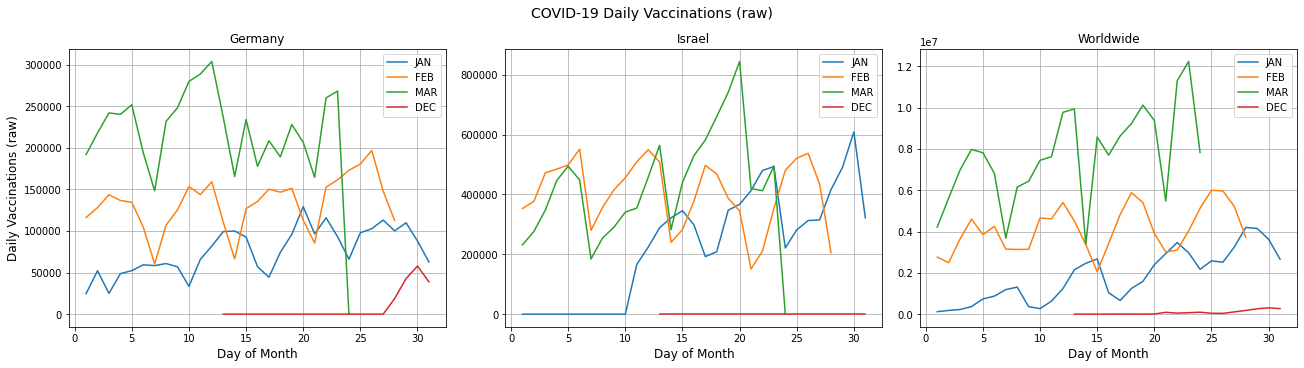

In [9]:
#Monthly comparison of daily vaccinations (raw) worldwide and for 2 countries (Germany and Israel)
#Define subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5), constrained_layout=True)

#Grouped dataframe for plotting
df_plot = df_timeseries.groupby([(df_timeseries.index.month),(df_timeseries.index.day)]).sum()

#Simple lineplots
df_plot.daily_vaccinations_raw_germany.unstack(level=0).plot(kind='line', grid=True, ax=ax[0])
df_plot.daily_vaccinations_raw_israel.unstack(level=0).plot(kind='line', grid=True, ax=ax[1])
df_plot.daily_vaccinations_raw.unstack(level=0).plot(kind='line', grid=True, ax=ax[2])

#Set title, axis labels and legends
fig.suptitle('COVID-19 Daily Vaccinations (raw)', fontsize='14')
ax[0].title.set_text('Germany')
ax[1].title.set_text('Israel')
ax[2].title.set_text('Worldwide')
ax[0].set_xlabel('Day of Month', fontsize='12')
ax[1].set_xlabel('Day of Month', fontsize='12')
ax[2].set_xlabel('Day of Month', fontsize='12')
ax[0].set_ylabel('Daily Vaccinations (raw)', fontsize='12')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].legend(['JAN', 'FEB', 'MAR', 'DEC'])
ax[1].legend(['JAN', 'FEB', 'MAR', 'DEC'])
ax[2].legend(['JAN', 'FEB', 'MAR', 'DEC'])

plt.show();

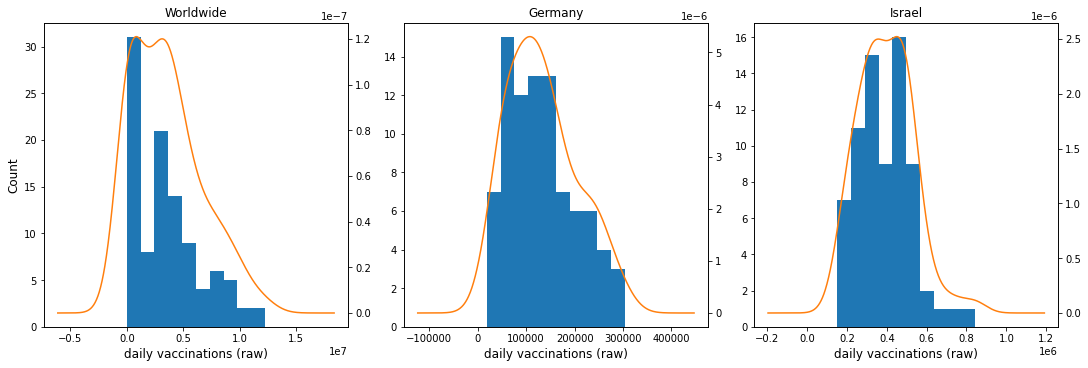

In [10]:
#Distribution of daily vaccinations (raw) worldwide and for 2 countries (Germany and Israel)
#Define subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), constrained_layout=True)

#Simple histogramms
df_timeseries.daily_vaccinations_raw.plot(kind='hist', ax=ax[0])
df_timeseries.daily_vaccinations_raw_germany.plot(kind='hist', ax=ax[1])
df_timeseries.daily_vaccinations_raw_israel.plot(kind='hist', ax=ax[2])

#KDE plots (CAVEAT: negative vaccination numbers due to skewedness towards zero)
df_timeseries.daily_vaccinations_raw.plot(kind='density', secondary_y=True, ax=ax[0])
df_timeseries.daily_vaccinations_raw_germany.plot(kind='density', secondary_y=True, ax=ax[1])
df_timeseries.daily_vaccinations_raw_israel.plot(kind='density', secondary_y=True, ax=ax[2])

#Set title and axis labels
ax[0].title.set_text('Worldwide')
ax[1].title.set_text('Germany')
ax[2].title.set_text('Israel')
ax[0].set_xlabel('daily vaccinations (raw)', fontsize='12')
ax[1].set_xlabel('daily vaccinations (raw)', fontsize='12')
ax[2].set_xlabel('daily vaccinations (raw)', fontsize='12')
ax[0].set_ylabel('Count', fontsize='12')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

plt.show();

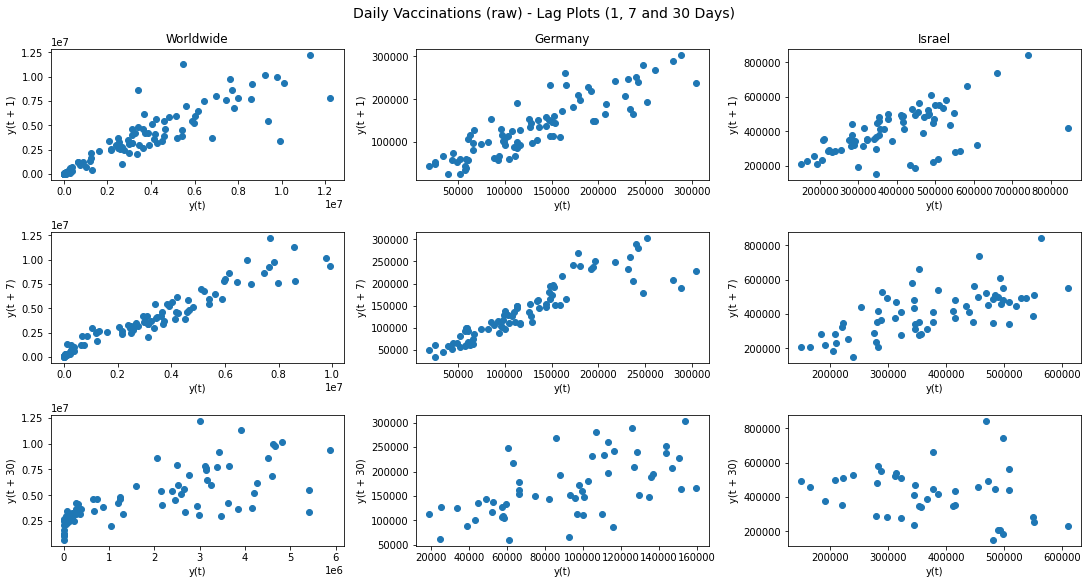

In [11]:
#Lag plots (1, 7 and 30 days)
#Define subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,8), constrained_layout=True)

#Lag plots to check for autocorrelation (linearity and outliers)
pd.plotting.lag_plot(df_timeseries.daily_vaccinations_raw, lag=1, ax=ax[0,0])
pd.plotting.lag_plot(df_timeseries.daily_vaccinations_raw_germany, lag=1, ax=ax[0,1])
pd.plotting.lag_plot(df_timeseries.daily_vaccinations_raw_israel, lag=1, ax=ax[0,2])

pd.plotting.lag_plot(df_timeseries.daily_vaccinations_raw, lag=7, ax=ax[1,0])
pd.plotting.lag_plot(df_timeseries.daily_vaccinations_raw_germany, lag=7, ax=ax[1,1])
pd.plotting.lag_plot(df_timeseries.daily_vaccinations_raw_israel, lag=7, ax=ax[1,2])

pd.plotting.lag_plot(df_timeseries.daily_vaccinations_raw, lag=30, ax=ax[2,0])
pd.plotting.lag_plot(df_timeseries.daily_vaccinations_raw_germany, lag=30, ax=ax[2,1])
pd.plotting.lag_plot(df_timeseries.daily_vaccinations_raw_israel, lag=30, ax=ax[2,2])

#Set title, axis labels and legends
fig.suptitle('Daily Vaccinations (raw) - Lag Plots (1, 7 and 30 Days)', fontsize='14')
ax[0,0].title.set_text('Worldwide')
ax[0,1].title.set_text('Germany')
ax[0,2].title.set_text('Israel')

plt.show();

***

### 2.3 Detrend to Achieve Stationarity

In this section we decompose the 3 time series and then detrend to achieve stationarity. These are preparation processes for choosing suitable models and transforming the series into the required formats.

#### **TASK 1**: Worldwide Daily Vaccinations (raw)

1) Time series decomposition
2) Detrending and stationarity test
3) Visualisation of detrended series and serial correlation plots

**KEY FINDINGS**:

1) The decomposition shows a positive trend with weekly seasonality and normally distributed residuals.
2) After detrending through a combination of seasonal and simple differencing the series is stationary according to KPSS and ADF tests.
3) The ACF and PACF plots for the detrended series show autocorrelation at lag 2 (and much less so at 10), and partial autocorrelation (correlation between a variable and its lags that is not explained by previous lags) at lags 1 and 3 (less so at 22 and 30).

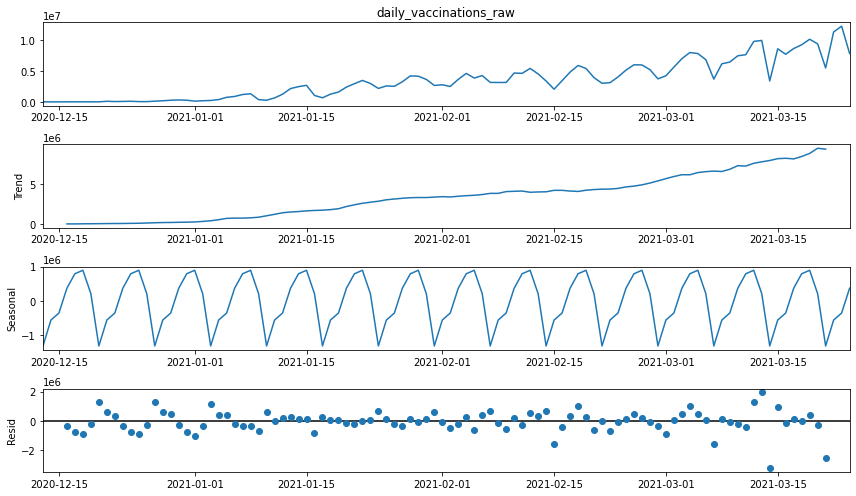

In [12]:
#Seasonal decomposition and plot for Worldwide Daily Vaccinations (raw)
decomposition = seasonal_decompose(df_timeseries.daily_vaccinations_raw, model='additive', period=7) #Account for weekly pattern
plt.rc('figure', figsize=(12,7))
resplot = decomposition.plot()

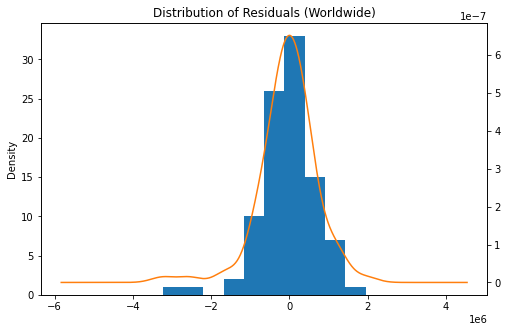

In [13]:
#Quick check on distribution of residuals
decomposition.resid.plot(kind='hist')
decomposition.resid.plot(kind='density', secondary_y=True, title='Distribution of Residuals (Worldwide)', figsize=(8,5));

In [14]:
#Stationarity through seasonal differencing and simple differencing to detrend
df_worldwide = df_timeseries.daily_vaccinations_raw.diff(periods=7).diff(periods=1)

#Drop rows with NaNs that were created during differencing process
df_worldwide = df_worldwide.dropna(axis=0).copy()

In [15]:
#Check for stationarity
print('====='*10)
print(f'Detrended worldwide time series:')


#Check if data is stationary around mean or trendline with KPSS (Kwiatkowski-Phillips-Schmidt-Shin-Tests)
stats, p, lags, critical_values = kpss(df_worldwide, regression='ct', nlags='auto')

print('====='*10)
print(f'KPSS test statistics: {round(stats, 3)}')
print(f'KPSS p-value: {round(p, 3)}')
print(f'KPSS critical values: {critical_values}')

if p < 0.05:
    print('Timeseries is NOT stationary.')
else:
    print('Timeseries is stationary.')

    
#Check if data is stationary around mean or trendline with ADF (Augmented Dickey-Fuller-Test)
result = adfuller(df_worldwide, regression='ct', autolag='AIC')

print('====='*10)
print(f'ADF test statistics: {round(result[0], 3)}')
print(f'ADF p-value: {round(result[1], 3)}')
print(f'ADF critical values: {result[4]}')

if result[1] > 0.05:
    print('Timeseries is NOT stationary.')
else:
    print('Timeseries is stationary.')

Detrended worldwide time series:
KPSS test statistics: 0.075
KPSS p-value: 0.1
KPSS critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Timeseries is stationary.
ADF test statistics: -3.765
ADF p-value: 0.018
ADF critical values: {'1%': -4.073644812103713, '5%': -3.46545759986071, '10%': -3.1592060271905518}
Timeseries is stationary.


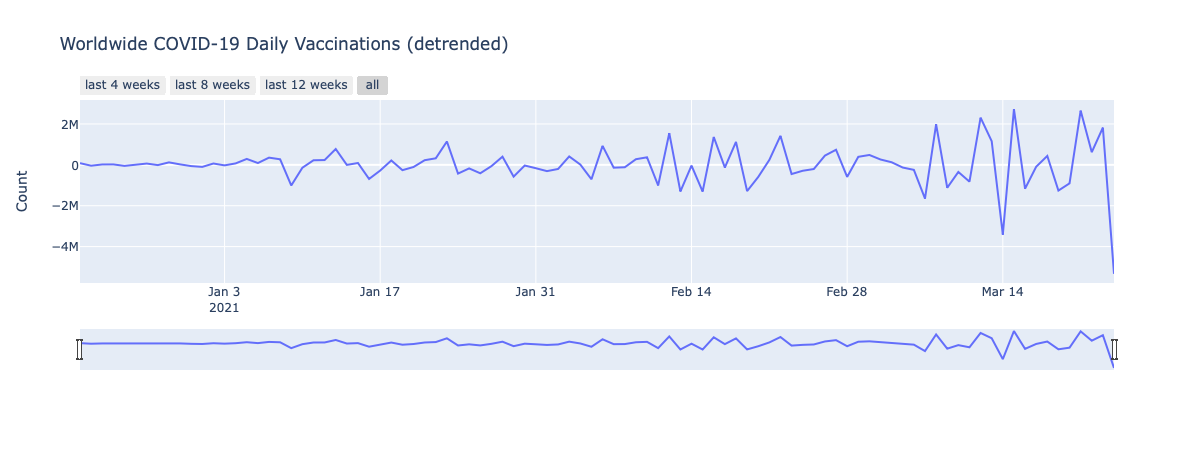

In [16]:
#Interactive PlotlyExpress graph for worldwide daily vaccinations (raw) after differencing
fig = px.line(df_worldwide.reset_index(), x='date', y='daily_vaccinations_raw',
              title='Worldwide COVID-19 Daily Vaccinations (detrended)',
              labels={'date': '', 'daily_vaccinations_raw': 'Count'})

#Define range slider and time-span buttons
fig.update_xaxes(
                rangeslider_visible=True,
                rangeselector=dict(
                    buttons=list([
                        dict(count=1, label='last 4 weeks', step='month', stepmode='backward'),
                        dict(count=2, label='last 8 weeks', step='month', stepmode='backward'),
                        dict(count=3, label='last 12 weeks', step='month', stepmode='backward'),
                        dict(step='all')
                        
                    ])
                )
)


fig.show();

![](images/nb6_fig3.png)

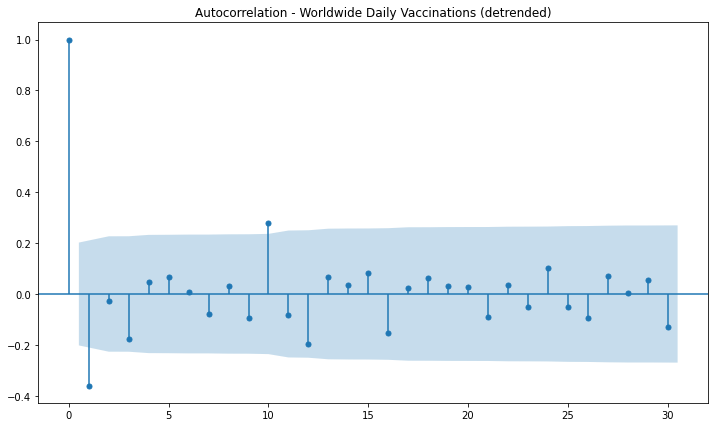

In [17]:
#Autocorrelation plot for worldwide daily vaccinations after detrending
acf = plot_acf(df_worldwide, lags=30, title='Autocorrelation - Worldwide Daily Vaccinations (detrended)')

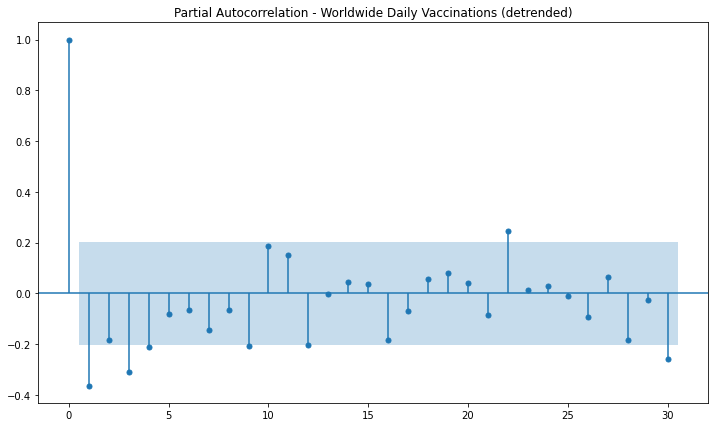

In [18]:
#Partial Autocorrelation Plot for worldwide daily vaccinations after detrending
pacf = plot_pacf(df_worldwide, lags=30, title='Partial Autocorrelation - Worldwide Daily Vaccinations (detrended)')

#### **TASK 2**: Daily Vaccinations (raw) - Germany

1) Time series decomposition
2) Detrending and stationarity test
3) Visualisation of detrended series and serial correlation plots

**KEY FINDINGS**:

1) The decomposition shows a positive trend with weekly seasonality and normally distributed residuals.
2) After detrending through seasonal differencing the series is stationary according to KPSS and ADF tests. Detrending through simple differencing achieved stationarity, but autocorrelationw as still quite strong.
3) The ACF and PACF plots for the detrended series show autocorrelation at laga 1 and 2, and a clear partial autocorrelation (correlation between a variable and its lags that is not explained by previous lags) at lags 1 and 30.

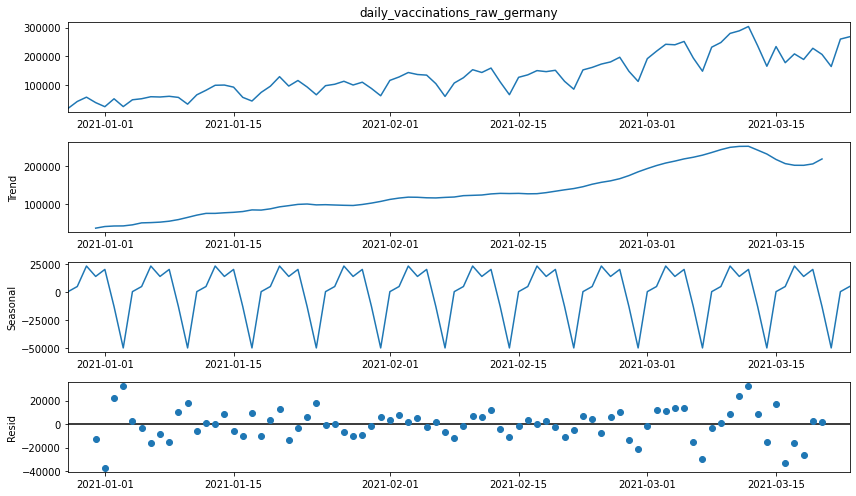

In [19]:
#Generate new series for germany and drop empties at the start
df_germany = df_timeseries.daily_vaccinations_raw_germany.dropna(axis=0).copy()

#Seasonal decomposition and plot for Daily Vaccinations (raw) for Germany
decomposition = seasonal_decompose(df_germany, model='additive', period=7) #Account for weekly pattern
plt.rc('figure', figsize=(12,7))
resplot = decomposition.plot()

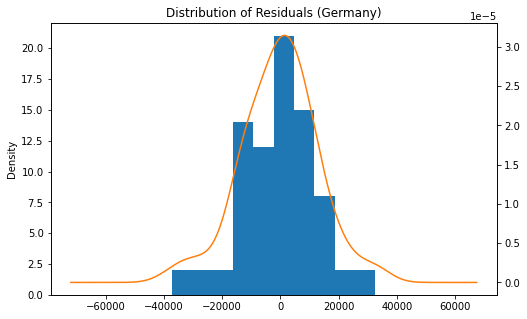

In [20]:
#Quick check on distribution of residuals
decomposition.resid.plot(kind='hist')
decomposition.resid.plot(kind='density', secondary_y=True, title='Distribution of Residuals (Germany)', figsize=(8,5));

In [21]:
#Stationarity through seasonal differencing
df_germany = df_germany.diff(periods=7)

#Drop rows with NaNs that were created during differencing process
df_germany = df_germany.dropna(axis=0).copy()

In [22]:
#Check for stationarity
print('====='*10)
print(f'Detrended time series for Germany:')

#Check if data is stationary around mean or trendline with KPSS (Kwiatkowski-Phillips-Schmidt-Shin-Tests)
stats, p, lags, critical_values = kpss(df_germany, regression='ct', nlags='auto')

print('====='*10)
print(f'KPSS test statistics: {round(stats, 3)}')
print(f'KPSS p-value: {round(p, 3)}')
print(f'KPSS critical values: {critical_values}')

if p < 0.05:
    print('Timeseries is NOT stationary.')
else:
    print('Timeseries is stationary.')

    
#Check if data is stationary around mean or trendline with ADF (Augmented Dickey-Fuller-Test)
result = adfuller(df_germany, regression='ct', autolag='AIC')

print('====='*10)
print(f'ADF test statistics: {round(result[0], 3)}')
print(f'ADF p-value: {round(result[1], 3)}')
print(f'ADF critical values: {result[4]}')

if result[1] > 0.05:
    print('Timeseries is NOT stationary.')
else:
    print('Timeseries is stationary.')

Detrended time series for Germany:
KPSS test statistics: 0.077
KPSS p-value: 0.1
KPSS critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Timeseries is stationary.
ADF test statistics: -3.592
ADF p-value: 0.031
ADF critical values: {'1%': -4.102930985196315, '5%': -3.4792434170910203, '10%': -3.167204658151766}
Timeseries is stationary.


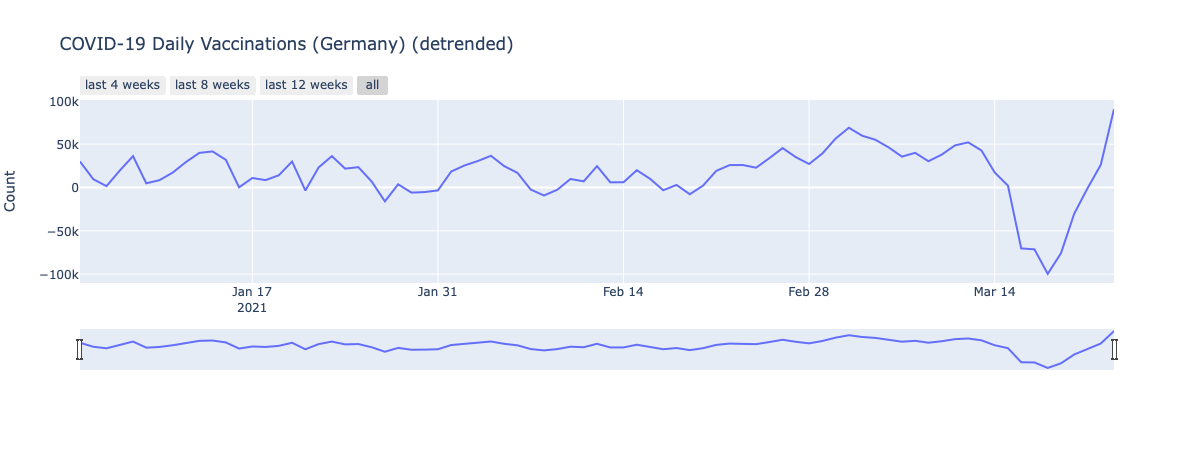

In [23]:
#Interactive PlotlyExpress graph for detrended daily vaccinations (Germany - raw) after differencing
fig = px.line(df_germany.reset_index(), x='date', y='daily_vaccinations_raw_germany',
              title='COVID-19 Daily Vaccinations (Germany) (detrended)',
              labels={'date': '', 'daily_vaccinations_raw_germany': 'Count'})

#Define range slider and time-span buttons
fig.update_xaxes(
                rangeslider_visible=True,
                rangeselector=dict(
                    buttons=list([
                        dict(count=1, label='last 4 weeks', step='month', stepmode='backward'),
                        dict(count=2, label='last 8 weeks', step='month', stepmode='backward'),
                        dict(count=3, label='last 12 weeks', step='month', stepmode='backward'),
                        dict(step='all')
                        
                    ])
                )
)


fig.show();

![](images/nb6_fig4.png)

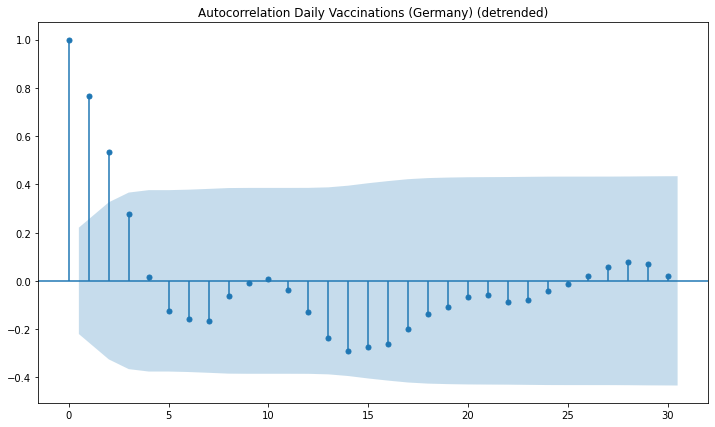

In [24]:
#Autocorrelation Plot for daily vaccinations (Germany) after detrending
acf = plot_acf(df_germany, lags=30, title='Autocorrelation Daily Vaccinations (Germany) (detrended)')

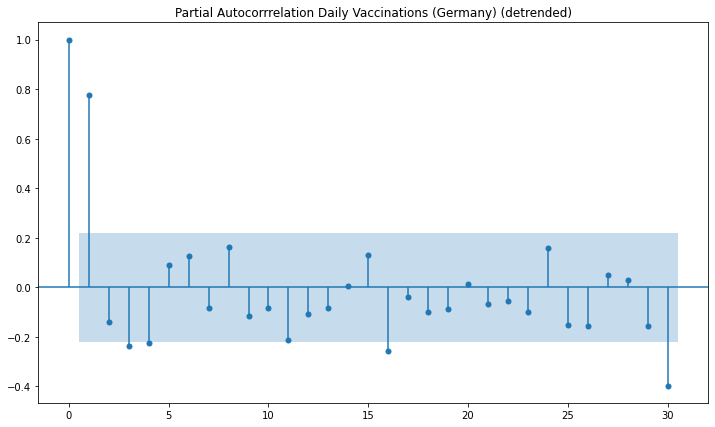

In [25]:
#Partial Autocorrelation Plot for daily vaccinations (Germany) after detrending
pacf = plot_pacf(df_germany, lags=30, title='Partial Autocorrrelation Daily Vaccinations (Germany) (detrended)')

#### **TASK 2**: Daily Vaccinations (raw) - Israel

1) Time series decomposition
2) Detrending and stationarity test
3) Visualisation of detrended series and serial correlation plots

**KEY FINDINGS**:

1) The decomposition shows a positive trend with weekly seasonality and normally distributed residuals.
2) After detrending through seasonal and simple differencing the series is stationary according to KPSS and ADF tests.
3) The PACF plots for the detrended series show autocorrelation at laga 16 and 28.

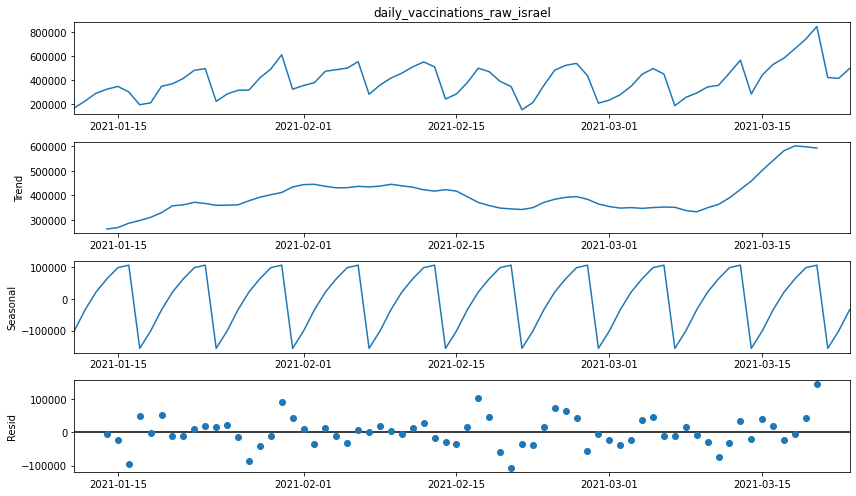

In [26]:
#Generate new series for germany and drop empties at the start
df_israel = df_timeseries.daily_vaccinations_raw_israel.dropna(axis=0).copy()

#Seasonal decomposition and plot for Daily Vaccinations (raw) for Germany
decomposition = seasonal_decompose(df_israel, model='additive', period=7) #Account for weekly pattern
plt.rc('figure', figsize=(12,7))
resplot = decomposition.plot()

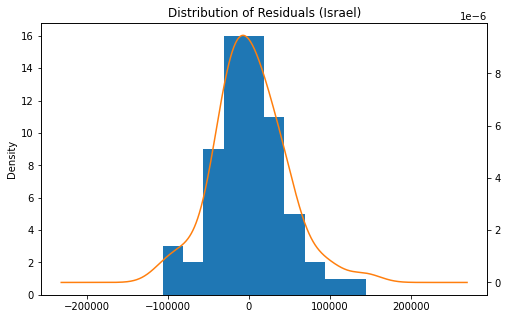

In [27]:
#Quick check on distribution of residuals
decomposition.resid.plot(kind='hist')
decomposition.resid.plot(kind='density', secondary_y=True, title='Distribution of Residuals (Israel)', figsize=(8,5));

In [28]:
#Stationarity through seasonal differencing and simple differencing to detrend
df_israel = df_israel.diff(periods=7).diff(periods=1)

#Drop rows with NaNs that were created during differencing process
df_israel = df_israel.dropna(axis=0).copy()

In [29]:
#Check for stationarity
print('====='*10)
print(f'Detrended time series for Israel:')

#Check if data is stationary around mean or trendline with KPSS (Kwiatkowski-Phillips-Schmidt-Shin-Tests)
stats, p, lags, critical_values = kpss(df_israel, regression='ct', nlags='auto')

print('====='*10)
print(f'KPSS test statistics: {round(stats, 3)}')
print(f'KPSS p-value: {round(p, 3)}')
print(f'KPSS critical values: {critical_values}')

if p < 0.05:
    print('Timeseries is NOT stationary.')
else:
    print('Timeseries is stationary.')

    
#Check if data is stationary around mean or trendline with ADF (Augmented Dickey-Fuller-Test)
result = adfuller(df_israel, regression='ct', autolag='AIC')

print('====='*10)
print(f'ADF test statistics: {round(result[0], 3)}')
print(f'ADF p-value: {round(result[1], 3)}')
print(f'ADF critical values: {result[4]}')

if result[1] > 0.05:
    print('Timeseries is NOT stationary.')
else:
    print('Timeseries is stationary.')

Detrended time series for Israel:
KPSS test statistics: 0.047
KPSS p-value: 0.1
KPSS critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Timeseries is stationary.
ADF test statistics: -7.288
ADF p-value: 0.0
ADF critical values: {'1%': -4.110169028582626, '5%': -3.482636994764984, '10%': -3.1691696870988255}
Timeseries is stationary.


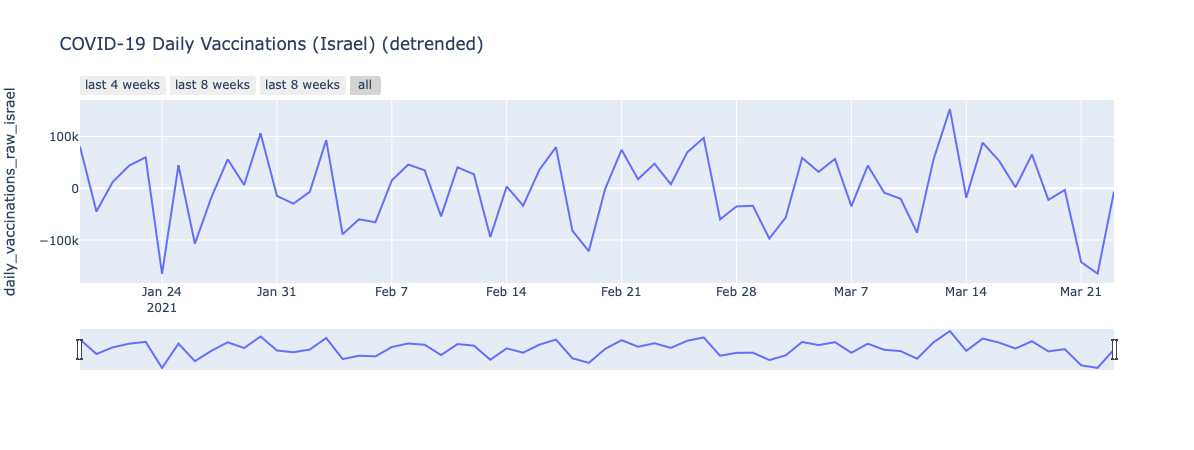

In [30]:
#Interactive PlotlyExpress graph for detrended daily vaccinations (Israel - raw) after differencing
fig = px.line(df_israel.reset_index(), x='date', y='daily_vaccinations_raw_israel',
              title='COVID-19 Daily Vaccinations (Israel) (detrended)',
              labels={'date': '', 'daily_vaccinations_raw_germany': 'Count'})

#Define range slider and time-span buttons
fig.update_xaxes(
                rangeslider_visible=True,
                rangeselector=dict(
                    buttons=list([
                        dict(count=1, label='last 4 weeks', step='month', stepmode='backward'),
                        dict(count=2, label='last 8 weeks', step='month', stepmode='backward'),
                        dict(count=3, label='last 8 weeks', step='month', stepmode='backward'),
                        dict(step='all')
                        
                    ])
                )
)


fig.show();

![](images/nb6_fig5.png)

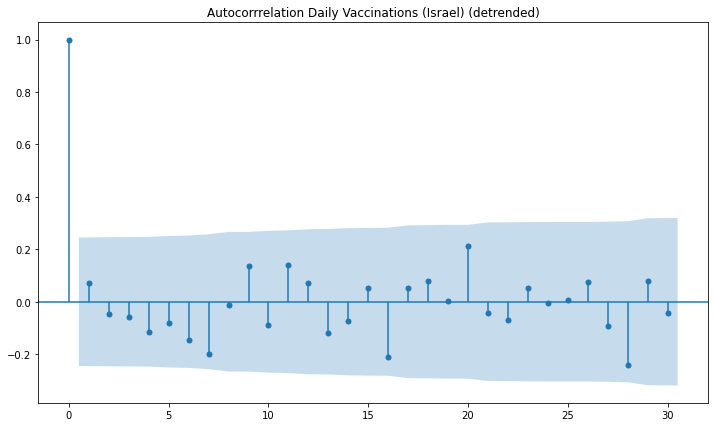

In [31]:
#Autocorrelation Plot for daily vaccinations (Israel) after detrending
acf = plot_acf(df_israel, lags=30, title='Autocorrrelation Daily Vaccinations (Israel) (detrended)')

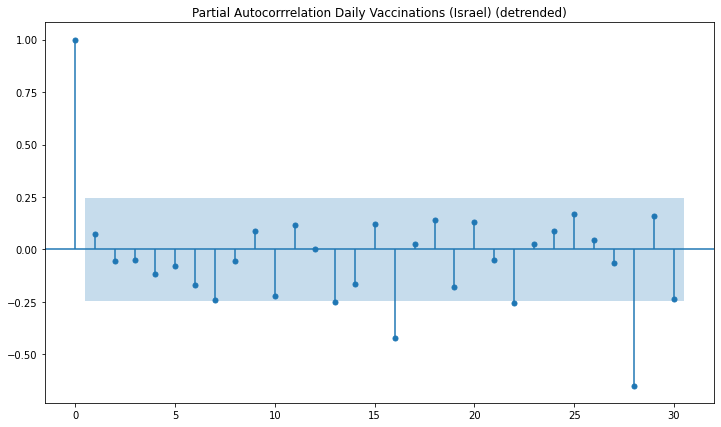

In [32]:
#Partial Autocorrelation Plot for daily vaccinations (Israel) after detrending
pacf = plot_pacf(df_israel, lags=30, title='Partial Autocorrrelation Daily Vaccinations (Israel) (detrended)')

***

In [33]:
#Save 3 univariate timeseries dataframes after differencing for use in later notebooks
#Global/worldwide
df_worldwide.to_csv('data/df_worldwide.csv')

#Germany
df_germany.to_csv('data/df_germany.csv')

#Israel
df_israel.to_csv('data/df_israel.csv')

***
***

## 3. SUMMARY

***

### 3.1 Key Findings

1) All 3 timeseries show a positive trend and a weekly seasonality.
2) All 3 timeseries were successfully detrended to achieve stationarity.

***Note:*** It is not clear whether the trends are linear or exponential, additional analysis would be required. Thinking about the process in general one could hope for a linear trend in the first months, then maybe an exponential trend for a while, before eventually becoming stationary as the world. population is vaccinated and requires re-vaccination (with then sufficient vaccine quantities available). And, looking at the detrended series it can be speculated that possibly trend stationarity may not be given for data in March. We will keep this in mind moving forward.

***

### 3.2 Next Steps

In the next notebooks we will model the 3 timeseries with focus on Holt-Winter's triple exponential smoothing, seasonal ARIMA and FB Prophet.

***REASONING:***
Simple exponential smoothing and Winter's exponential smoothing will not be applied due to their specific requirements regarding trend and seasonality. Triple exponential smoothing tolerates both and is hence best suited for our timeseries. With our newly generated detrended time series we will further investigate an autoregressive SARIMA model. If successful we can advance to a SARIMAX or vector-autoregressive (VAR) model allowing for multivariate time series (i.e. lag observations from other variables). Alternatively, if facing challenges we can turn to FB Prophet, an additive regression model with changepoint analysis, which can handle non-stationary data and allows for the inclusion of additional regressors, such as holidays and other metadata (e.g. day of week). Another allternative would be a neural network (LSTM), however this would require a lot of data, which is currently not available with COVID-19 vaccinations only having started about 100 days ago. So, this will be placed on hold for now, since interpolation of the daily data would not suffice either, but might certainly be an option in the future. And, we might then also include FB Neural Prophet.

***